In [20]:
from random import seed
from random import randrange
from csv import reader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

In [21]:
# Load a CSV file
def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

In [22]:
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

In [23]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [24]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [25]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [26]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [27]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
# count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [28]:
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [29]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [30]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [31]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root

In [32]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [33]:
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

In [34]:
# Test CART on Bank Note dataset
seed(1)
# load and prepare data
filename = 'data.csv'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(len(dataset[0])):
	str_column_to_float(dataset, i)
# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
v=sum(scores)/float(len(scores))
print('Mean Accuracy: %.3f%%' % (v))

Scores: [97.08029197080292, 97.08029197080292, 96.35036496350365, 96.71532846715328, 97.08029197080292]
Mean Accuracy: 96.861%


In [35]:
import sklearn.datasets as datasets
import pandas as pd
iris=datasets.load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target

In [36]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
dtree.fit(df,y)

DecisionTreeClassifier()

In [37]:
from sklearn.ensemble import RandomForestClassifier
# Limit max depth
model = RandomForestClassifier(max_depth = 5, n_estimators=10)
# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator_limited = model.estimators_[5]
estimator_limited

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, 
            random_state=1538259045, splitter='best')
# No max depth
model = RandomForestClassifier(max_depth = None, n_estimators=10)
model.fit(iris.data, iris.target)
estimator_nonlimited = model.estimators_[5]

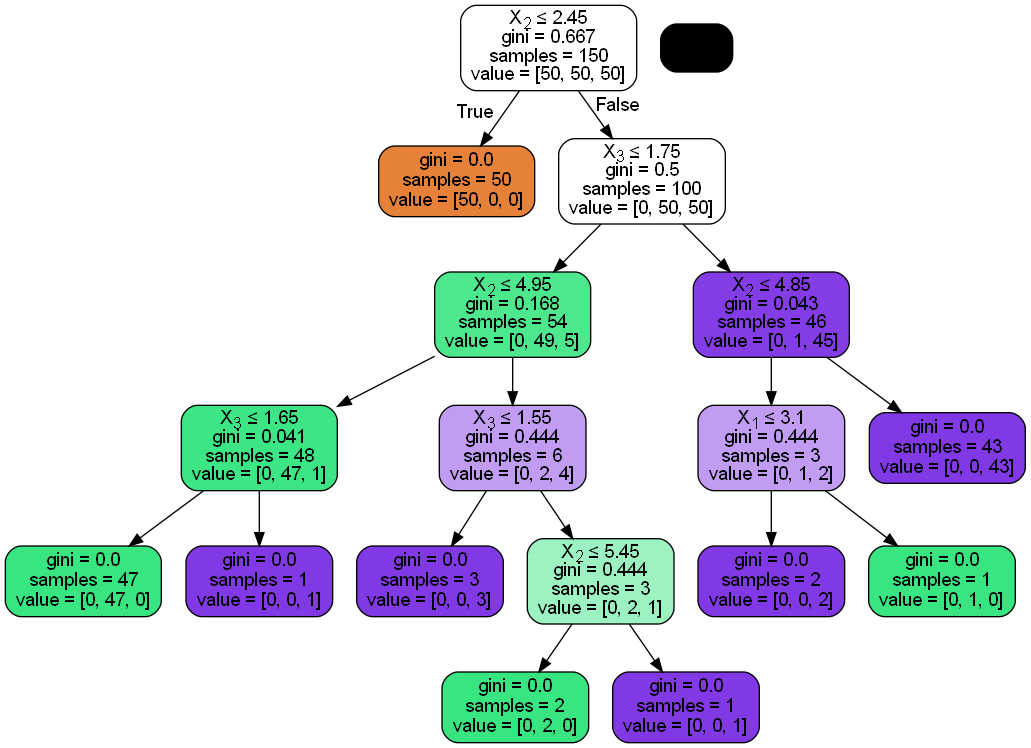

In [38]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())